In [2]:
import os
import platform
import cv2 as cv
import json
import numpy as np
import tensorflow as tf
import pandas as pd

from sys import path
path.insert(0, '..')
import model_lite
import config
import utill
import layer

In [4]:
with open('../assets/dataset/gt_train.txt') as file:
  data = json.load(file)

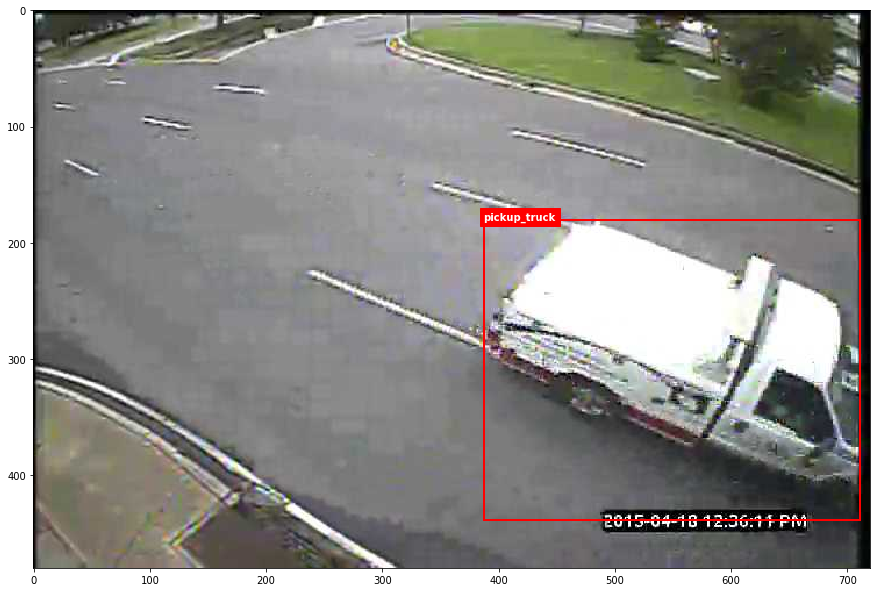

In [5]:
s = 10
img = utill.open_image(os.path.join('../assets/dataset/train',data[s]['filename']), False)
utill.draw_image(img, data[s])

In [3]:
class_name = [line.strip() for line in open('../assets/class_name.txt').readlines()]

In [6]:
interpreter = tf.lite.Interpreter(model_path='../assets/model-503.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [7]:
print(input_details[0]['shape'])

[  1 416 416   3]


In [8]:
def img_process(img, shape):
  img_ori = tf.image.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][1]))
  img_ori = img_ori / 255
  img_exp = np.expand_dims(img_ori, axis=0)
  return img_exp

In [10]:
imgf = img_process(img, input_details)
print(imgf.shape)

(1, 416, 416, 3)


In [11]:
interpreter.set_tensor(input_details[0]['index'], imgf)
interpreter.invoke()

In [15]:
anchors = np.array(config.cfg_lite['anchors']).reshape((2, 6, 2))
large_output = interpreter.get_tensor(output_details[0]['index'])
medium_output = interpreter.get_tensor(output_details[1]['index'])
outputs = [large_output, medium_output]

outputs = layer.yolo_detector_lite(outputs, anchors, len(class_name) , config.cfg_lite['strides'], config.cfg_lite['xyscale'])
outputs = utill.nms(outputs, config.cfg_lite['image_size'], len(class_name), config.cfg_lite['iou_threshold'], config.cfg_lite['score_threshold'])
boxes = utill.get_detection_data(outputs, img.shape, class_name)
boxes = utill.filtter(boxes, 0.7)

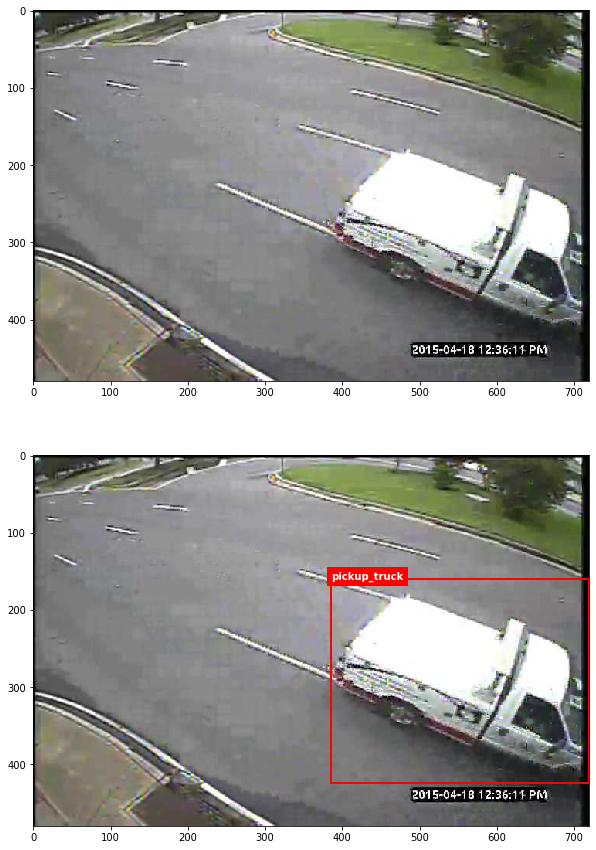

In [16]:
utill.plot_bbox(img, boxes, True)

In [18]:
print(boxes)

    x1   y1   x2   y2    class_name     score    w    h
0  385  160  719  424  pickup_truck  0.998527  334  264
